In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Flatten,GlobalAveragePooling2D,Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from os import walk
import gc
from sklearn.metrics import confusion_matrix,accuracy_score

Using TensorFlow backend.


In [2]:
PATH = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

BATCH_SIZE = 16 # lowering the batch will incerase accuracy but slows down the learning and vice versa
W = H = 384 # given that data's minimum dimension value is 384
EPOCH = 30 # WE have used  Early Stopping Callback so 30 is the Max Epoch. Hardware Constraints

# Input 

### Visualize and Explore data

In [3]:
generator = ImageDataGenerator(rescale=1./255.) # instantiate a data generator objct
batches = generator.flow_from_directory(PATH,class_mode='categorical',batch_size=15) 
# get all the images from directory with 16 random images at a time each with a dimension of (256,256)

Found 2527 images belonging to 6 classes.


In [4]:
print('Classes are mapped as:\n',batches.class_indices)

Classes are mapped as:
 {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


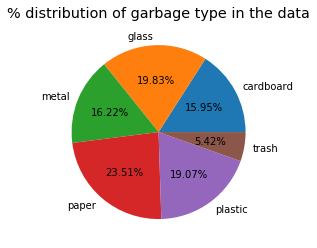

In [5]:
plt.title('% distribution of garbage type in the data',size='x-large')
plt.pie(np.bincount(batches.classes)/len(batches.classes),labels=batches.class_indices,autopct='%.2f%%')
plt.savefig('piechart.png')

In [6]:
images, labels = batches.next()  # look at a random batch which has 16 images
images.shape 

(15, 256, 256, 3)

we have 15 images in each batch each with a width and height of (256,256) and 3 channels (RGB)

### Plot Random images

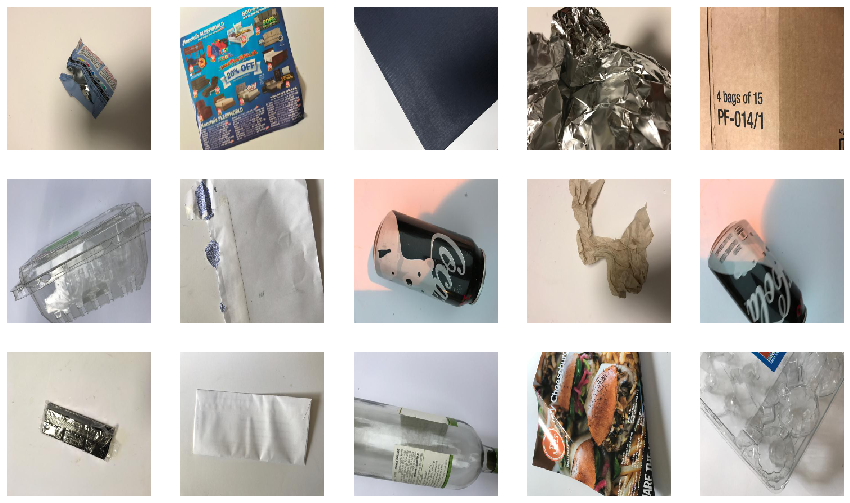

In [7]:
f,ax = plt.subplots(3,5,figsize=(15,9))
ax = ax.ravel()
for i,image in enumerate(images):
    ax[i].imshow((image))
    ax[i].axis('off')
    
plt.savefig('random_images.png')

## Image Augmentation
We are having very less data so we will use Augmentation using Keras' ImageDataGenerator to augment the data to get modified versions of the image. ImageDataGenerator does not create new images but AUGMENT the existing images that too single version per epoch.

See it something like that it has an infinite number of options from the set we have given it. Depending on the number of epochs, it'll create a new augment batch. Every batch will have some different versions of each image.

For example, if we had rotation,crop = 0.2,0.4 in the first epoch then we can have 0.3,0.45 in the next version for the same image and so on for each epoch given we have set our max rotation and max crop argument inside `ImageDataGenerator` to <=0.3 and 0.45 respectively. 

In other words, it will randomly choose the transformations form a set of transformation decided for an image and with this approach, we can have an infinite number of images from a single image.

Found 2527 images belonging to 6 classes.


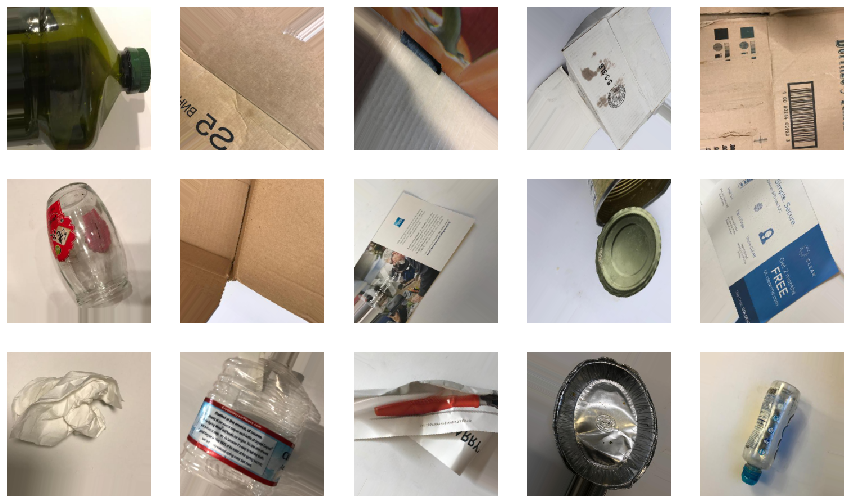

In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,rotation_range=360,
                                   width_shift_range=0.1,height_shift_range=0.1,
                                   shear_range=0.1,zoom_range=0.17,
                                   horizontal_flip=True, vertical_flip=True,
                                   fill_mode='nearest',)

dummy_aug_generator = train_datagen.flow_from_directory(PATH,batch_size=15,class_mode='categorical')


augmented_images, labels = dummy_aug_generator.next()


f,ax = plt.subplots(3,5,figsize=(15,9))
ax = ax.ravel()
for i,image in enumerate(augmented_images):
    ax[i].imshow((image))
    ax[i].axis('off')
    
plt.savefig('random_aug_images.png')

## Free up Memory

In [9]:
del generator,batches,images,labels,train_datagen,dummy_aug_generator,augmented_images
gc.collect()

29405

# Preprocessing and Preparing Data

In [10]:
gen=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         rescale=1./255,
                         shear_range = 0.13,
                         zoom_range = 0.17,
                         width_shift_range = 0.11,
                         height_shift_range = 0.12,validation_split=0.11)


train = gen.flow_from_directory(PATH,subset='training',target_size=(W,H),
                                          batch_size=BATCH_SIZE,
                                          class_mode='categorical')


val = gen.flow_from_directory(PATH,target_size=(W,H),batch_size=BATCH_SIZE,
                                        class_mode='categorical',subset='validation')

Found 2250 images belonging to 6 classes.
Found 277 images belonging to 6 classes.


# Build Model

In [11]:
inputs = Input(shape=(W, H, 3))
x = Conv2D(32,(3,3), padding='same',activation='relu')(inputs)
# x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(64,(3,3), padding='same',activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(64,(3,3), padding='same',activation='relu')(x)
#x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(32,(3,3), padding='same',activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(32,(3,3), padding='same',activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.33)(x)
out = Dense(6, name='out',activation='softmax')(x)


model = Model(inputs=inputs, outputs= out)
model.compile(optimizer=Adam(lr=0.001),metrics=['accuracy'],loss='categorical_crossentropy')

In [12]:
plot_model(model,show_shapes=True)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 384, 384, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 384, 384, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 384, 384, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 192, 192, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 192, 192, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 192, 192, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 96, 96, 32)        0   

In [13]:
# cp = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',verbose=1,save_best_only=True)
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=8, verbose=100, restore_best_weights=True)
rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=4, verbose=1, min_delta=0.01,min_lr=0.0001)
callbacks = [es,rlp]

In [14]:
model.save_weights('model.hdf5')

In [15]:
history1 = model.fit_generator(train,steps_per_epoch=train.n//BATCH_SIZE,epochs=EPOCH,callbacks=callbacks,
                              validation_data=val,validation_steps=val.n//BATCH_SIZE,)

Epoch 1/111
140/140 [==============================] - 112s 800ms/step - loss: 1.6467 - accuracy: 0.3004 - val_loss: 1.6622 - val_accuracy: 0.3419
Epoch 2/111
140/140 [==============================] - 91s 651ms/step - loss: 1.4464 - accuracy: 0.4134 - val_loss: 1.8280 - val_accuracy: 0.4291
Epoch 3/111
140/140 [==============================] - 91s 650ms/step - loss: 1.4154 - accuracy: 0.4358 - val_loss: 1.1459 - val_accuracy: 0.4521
Epoch 4/111
140/140 [==============================] - 90s 646ms/step - loss: 1.3458 - accuracy: 0.4664 - val_loss: 1.4672 - val_accuracy: 0.4559
Epoch 5/111
140/140 [==============================] - 91s 649ms/step - loss: 1.3221 - accuracy: 0.4848 - val_loss: 1.1819 - val_accuracy: 0.4866
Epoch 6/111
140/140 [==============================] - 90s 644ms/step - loss: 1.2710 - accuracy: 0.5013 - val_loss: 1.2007 - val_accuracy: 0.4636
Epoch 7/111
140/140 [==============================] - 91s 650ms/step - loss: 1.2603 - accuracy: 0.5152 - val_loss: 1.3148 

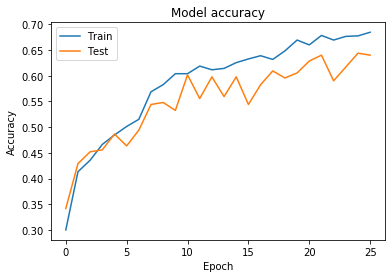

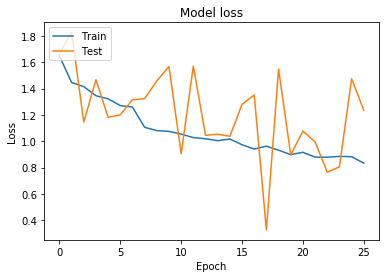

In [16]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_acc.png')
plt.show()

# Plot training & validation loss values
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_loss.png')
plt.show()

## Transfer Learning

In [17]:
from keras.applications.vgg19 import VGG19

In [18]:
train = gen.flow_from_directory(PATH,subset='training',target_size=(W,H),
                                          batch_size=BATCH_SIZE,
                                          class_mode='categorical')


val = gen.flow_from_directory(PATH,target_size=(W,H),batch_size=BATCH_SIZE,
                                        class_mode='categorical',subset='validation')

Found 2250 images belonging to 6 classes.
Found 277 images belonging to 6 classes.


In [19]:
base_model = VGG19(weights=None,include_top=False,input_shape=(W,H,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(254, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(6, activation='softmax')(x)
modelvgg = Model(inputs=base_model.input, outputs=out)

    
modelvgg.compile(optimizer=Adam(lr=0.001),metrics=['accuracy'],loss='categorical_crossentropy')

history_vgg = modelvgg.fit_generator(train,steps_per_epoch=train.n//BATCH_SIZE,epochs=EPOCH,callbacks=callbacks,
                              validation_data=val,validation_steps=val.n//BATCH_SIZE,)


Epoch 1/111
140/140 [==============================] - 115s 824ms/step - loss: 2.9421 - accuracy: 0.2274 - val_loss: 1.7542 - val_accuracy: 0.2390
Epoch 2/111
140/140 [==============================] - 115s 823ms/step - loss: 1.7264 - accuracy: 0.2287 - val_loss: 1.7443 - val_accuracy: 0.2337
Epoch 3/111
140/140 [==============================] - 114s 816ms/step - loss: 1.7333 - accuracy: 0.2332 - val_loss: 1.6506 - val_accuracy: 0.2299
Epoch 4/111
140/140 [==============================] - 113s 810ms/step - loss: 1.7254 - accuracy: 0.2395 - val_loss: 1.8230 - val_accuracy: 0.2529
Epoch 5/111
140/140 [==============================] - 114s 813ms/step - loss: 1.7239 - accuracy: 0.2296 - val_loss: 1.7564 - val_accuracy: 0.2222
Epoch 6/111
140/140 [==============================] - 114s 812ms/step - loss: 1.7278 - accuracy: 0.2368 - val_loss: 1.6739 - val_accuracy: 0.2414
Epoch 7/111
140/140 [==============================] - 112s 803ms/step - loss: 1.7296 - accuracy: 0.2323 - val_loss: 1

In [20]:
modelvgg.save_weights('modelvgg.hdf5')

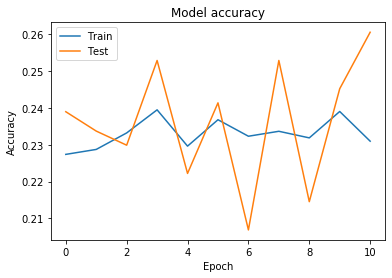

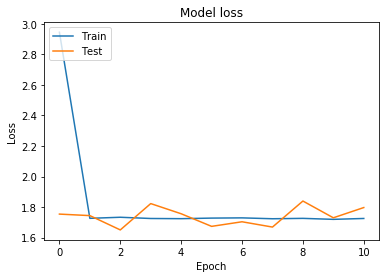

In [21]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_vgg_acc.png')
plt.show()

# Plot training & validation loss values
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_vgg_loss.png')
plt.show()

## Improvements

We can improve our model by using the Object Segementation or Seperation from the whole image so that Background is different from the image. We have used 2 different approaches for this
1. Otsu's Threshold with Watershed Algorithm
2. Canny Algorithm with Contours

In [2]:
def process_n_get_gray(img):
    '''
    process a numpy array or a string to filepath to get the grayscale image
    '''
    
    if type(img) == str:
        img = cv2.imread(filepath)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
    else:
        if img.max()<=1:
            img = np.array(img*255).astype('uint8')
        else:
            img = img.astype('uint8')
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        
    return img,gray


def smart_canny(image, sigma=0.33):
    '''
    method to apply Canny Algorithm on the image by automatically finding the thresholds
    '''
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    image = cv2.Canny(image, lower, upper)
    return image


def edge_detection(img,gauss_kernel=(3,3),get_blurred=False):
    '''
    Detect Edges using Smart Canny Algorithm after applying Gaussian Filter
    '''
    _,gray = process_n_get_gray(img)
    blurred = cv2.GaussianBlur(gray,gauss_kernel, 0)
    edged = smart_canny(blurred) # find edges from SMART Canny Defined above
    if get_blurred:
        return edged,blurred
    else:
        return edged

## Otsu - Watershed

In [6]:
def otsu_watershed_obj_seperation(img):
    
    img,gray = process_n_get_gray(img)
        
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # noise removal
    kernel = np.ones((2,2),np.uint8)
    # opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    
    closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
    
    sure_bg = cv2.dilate(closing,kernel,iterations=3)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)

    # Threshold
    ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers = cv2.watershed(img,markers)
    img[markers == -1] = [255,0,0]
    
    return img

## Canny Contour

In [7]:
def canny_contour_obj_seperation(img,add_alpha=False):
    BLUR = 21
    
    CANNY_THRESH_1 = 10 # min threshold for edge detection. use 0.33*mean_or_mode_of_image
    CANNY_THRESH_2 = 200 # max for Canny. use 1.33*mean_or_mode_of_image
    
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = (0.1,0.0,0.0) # In RGB format

    # Get a CV2 image and Grayscale version
    img,gray = process_n_get_gray(img)
    
    #-- Edge detection-- #
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    #-- Find contours in edges, sort by area --#
    contour_info = []
    contours,_ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
   
    # contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    for c in contours:
        contour_info.append((c,cv2.isContourConvex(c),cv2.contourArea(c),))
        
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]
    
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour--#
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))
    
    #-- Smooth mask, then blur it --#
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)
    
    # Create 3-channel alpha mask
    #-- Blend masked img into MASK_COLOR background --#
    
    mask_stack = mask_stack.astype('float32') / 255.0
    
    # Use float matrices,
    img = img.astype('float32') / 255.0
    
    # for easy blending
    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')
    # Convert back to 8-bit
    
    
    if add_alpha:
        #MAKE THE BACKGROUND TRANSPARENT by adding an alpha channel 
        c_red, c_green, c_blue = cv2.split(img)
        # merge with mask got on one of a previous steps
        img_a = cv2.merge((c_red, c_green, c_blue, mask.astype('float32') / 255.0))
        return img_a
    
    else:
        return masked

In [ ]:
generator = ImageDataGenerator(rescale=1./255.)
batches = generator.flow_from_directory(PATH,class_mode='categorical',batch_size=8) 
images,labels = next(batches)

f,ax = plt.subplots(2,4,figsize=(15,7))
ax = ax.ravel()

j=0
for i in range(0,8,2):
    ax[i].imshow(otsu_watershed_obj_seperation(images[i]))
    ax[i].set_title('Otsu Watershed')
    ax[i].axis('off')
    
    ax[i+1].imshow(canny_contour_obj_seperation(images[i]))
    ax[i+1].set_title('Canny Contour')
    ax[i+1].axis('off')
    

plt.savefig('obj_sep.png')
plt.show()

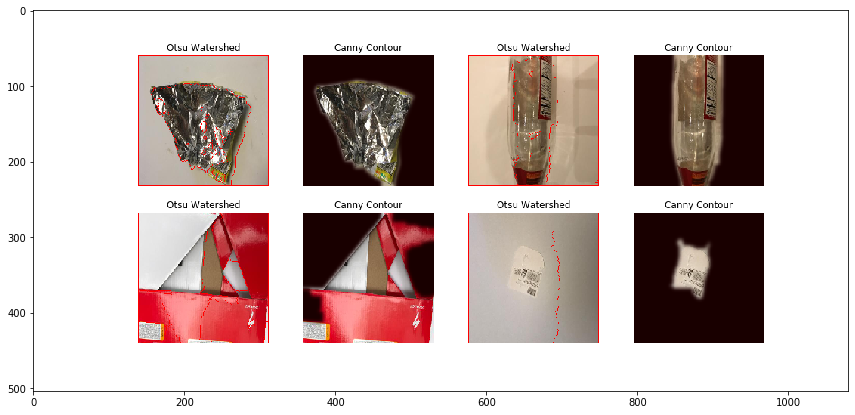

In [11]:
fig = plt.figure(figsize=(15,7))
plt.imshow(plt.imread('results/obj_sep.png'))

If we use the Canny and Contour method with Red or some other Color Background,We can have a better result